## Inference with the model on openEO

Make sure to upload your model to a publicly available location, such as a cloud storage service. Make sure the file is downloadable by testing the link with e.g. wget.

In [1]:
import openeo
from features import preprocess_features

import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Test parameters
bbox = {"west": 5.00, "south": 51.20, "east": 5.01, "north": 51.21}
temporal_extent = ("2018-01-01", "2018-12-31")

# Setup the connection
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [3]:

# Load S1 and S2 collections
s1 = connection.load_collection(
    "SENTINEL1_GRD",
    spatial_extent= bbox,
    temporal_extent=temporal_extent,
    bands=["VH", "VV"],
).sar_backscatter( # GFMap performed this step in the extraction
    coefficient="sigma0-ellipsoid"
)
s2 = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent= bbox,
    temporal_extent=temporal_extent,
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B11", "B12", "SCL"],
)

# Preprocess the features
features = preprocess_features(s2_datacube=s2, s1_datacube=s1)

In [4]:
# Supply the model as a URL and create an UDF from a file
model_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/grasslandwatch/lc_offline/random_forest.onnx"
udf = openeo.UDF.from_file(
    "udf_rf_onnx.py", 
    context={
        "model_url": model_url
    }
)

# Reduce the bands dimesnion to a single prediction using the udf
prediction = features.reduce_bands(reducer=udf)

# Add the onnx dependencies to the job options. You can reuse this existing dependencies archive
dependencies_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/openeo/onnx_dependencies_1.16.3.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps"
    ],
}

prediction_job = prediction.create_job(
    out_format="netcdf",
    job_options=job_options,
    title="LC_prediction"
)
prediction_job.start_and_wait()

0:00:00 Job 'j-2403211a825743799e83f012edf963ca': send 'start'
0:00:15 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:00:20 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:00:27 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:00:36 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:00:46 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:00:59 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:01:14 Job 'j-2403211a825743799e83f012edf963ca': created (progress N/A)
0:01:34 Job 'j-2403211a825743799e83f012edf963ca': running (progress N/A)
0:01:58 Job 'j-2403211a825743799e83f012edf963ca': running (progress N/A)
0:02:28 Job 'j-2403211a825743799e83f012edf963ca': running (progress N/A)
0:03:05 Job 'j-2403211a825743799e83f012edf963ca': running (progress N/A)
0:03:52 Job 'j-2403211a825743799e83f012edf963ca': running (progress N/A)
0:04:51 Job 'j-2403211a825743799e83f012edf963ca': running (pr

In [ ]:
prediction_job.download_results("prediction.nc")

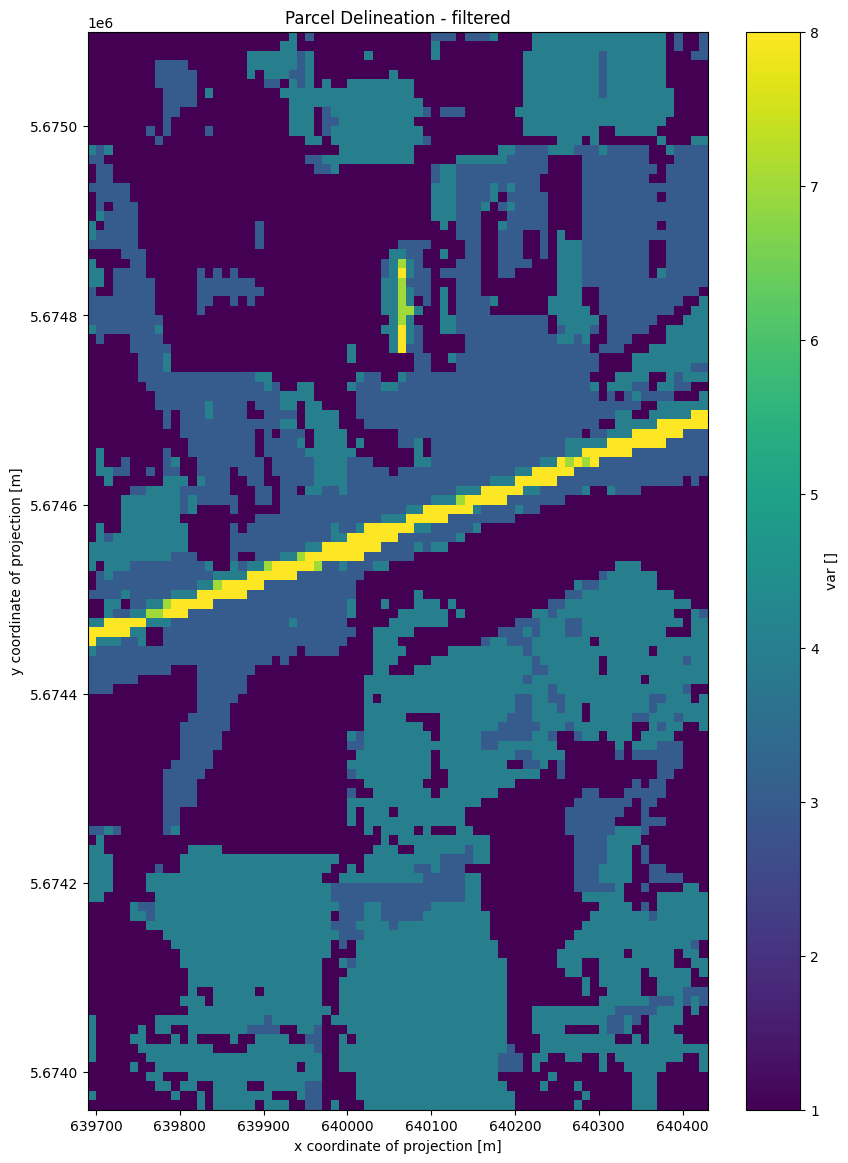

In [ ]:
## Load your dataset
ds = xr.open_dataset("prediction.nc")

## Access the "var" variable
var = ds["var"]

## Plot the data
var.plot(figsize=(10, 14))  # Use a colormap that suits your data
plt.title("Parcel Delineation - filtered")
plt.show()

## Close the dataset
ds.close()